In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from evaluate import load
import torch

/home/cmyu/anaconda3/envs/tvm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_name = "/home/cmyu/nn_pruning/output_models/sparse-bert-base-mrpc/checkpoint-1610"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # MRPC 是二分类任务

OSError: /home/cmyu/nn_pruning/output_models/sparse-bert-base-mrpc/checkpoint-1610 does not appear to have a file named config.json. Checkout 'https://huggingface.co//home/cmyu/nn_pruning/output_models/sparse-bert-base-mrpc/checkpoint-1610/None' for available files.

In [2]:
from examples.text_classification.glue_sparse_xp import GlueSparseXP
model_name = "/home/cmyu/nn_pruning/output_models/mrpc-t5-small-sparse"
model = GlueSparseXP.compile_model(model_name)

Some weights of the model checkpoint at /home/cmyu/nn_pruning/output_models/mrpc-t5-small-sparse were not used when initializing T5ForSequenceClassification: ['transformer.encoder.block.3.layer.1.DenseReluDense.wo.mask_module.context_modules.0.mask_scores', 'transformer.decoder.block.2.layer.1.EncDecAttention.q.mask_module.context_modules.0.mask_scores', 'transformer.decoder.block.5.layer.1.EncDecAttention.k.mask_module.context_modules.0.mask_scores', 'transformer.encoder.block.2.layer.0.SelfAttention.o.mask_module.context_modules.0.mask_scores', 'transformer.encoder.block.1.layer.1.DenseReluDense.wi.mask_module.context_modules.0.mask_scores', 'transformer.decoder.block.4.layer.1.EncDecAttention.v.mask_module.context_modules.0.mask_scores', 'transformer.decoder.block.3.layer.1.EncDecAttention.q.mask_module.context_modules.0.mask_scores', 'transformer.decoder.block.4.layer.0.SelfAttention.v.mask_module.context_modules.0.mask_scores', 'transformer.decoder.block.2.layer.0.SelfAttention.q.

<class 'nn_pruning.model_structure.T5Structure'>


In [3]:
model.bert.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=1024, out_features=1024, bias=True)
      (key): Linear(in_features=1024, out_features=1024, bias=True)
      (value): Linear(in_features=1024, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=1024, out_features=1024, bias=True)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=1024, out_features=4096, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=4096, out_features=1024, bias=True)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

bert.encoder.layer.11.intermediate.dense.weight


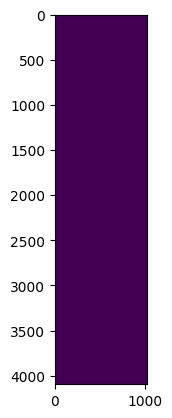

bert.encoder.layer.11.attention.output.dense.weight


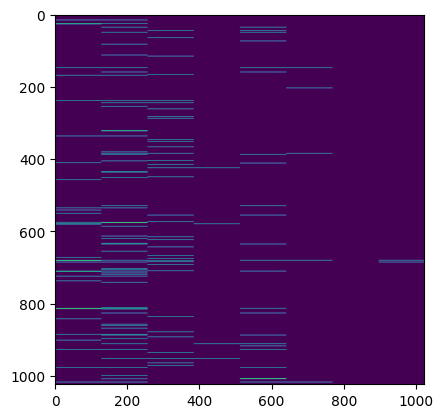

In [7]:
from matplotlib import pyplot as plt

parameters = dict(model.named_parameters())
param_names = ["bert.encoder.layer.11.intermediate.dense.weight",
               "bert.encoder.layer.11.attention.output.dense.weight"]

for param_name in param_names:          
    w = parameters[param_name]
    print(param_name)

    plt.imshow((w==0).detach().cpu())
    plt.show()

In [3]:
from nn_pruning.inference_model_patcher import optimize_model
model = optimize_model(model, mode="dense", clone=False)

<class 'nn_pruning.model_structure.T5Structure'>
removed heads 0, total_heads=144, percentage removed=0.0
transformer.encoder.block.0.layer.1.DenseReluDense.wi, sparsity = 0.20
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cmyu/anaconda3/envs/tvm/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1706764/2736949180.py", line 2, in <module>
    model = optimize_model(model, mode="dense", clone=False)
  File "/home/cmyu/nn_pruning/nn_pruning/inference_model_patcher.py", line 280, in optimize_model
  File "/home/cmyu/nn_pruning/nn_pruning/inference_model_patcher.py", line 236, in patch_model
  File "/home/cmyu/nn_pruning/nn_pruning/model_patcher.py", line 71, in patch
    self.replace_module(father, k, child_name, v, patch_info)
  File "/home/cmyu/nn_pruning/nn_pruning/model_patcher.py", line 44, in replace_module
    new_child_module = self.new_child_module(child_module_name, child_module, patch_info)
  File "/home/cmyu/nn_pruning/nn_pruning/inference_model_patcher.py", line 222, in new_child_module
    elif self.mode == "heads":
  File "/home/cmyu